{/* cspell:ignore arrowstyle UCCSD verticalalignment horizontalalignment  xytext arrowprops preparable ansätze Marov Aspuru Guzik Hartrees ansä */}



# Variational Quantum Eigensolver (VQE)

For this module, people must have a working Python environment, and the latest versions of the following packages installed:

*   `qiskit`
*   `qiskit_ibm_runtime`
*   `qiskit-aer`
*   `qiskit.visualization`
*   `numpy`
*   `pylatexenc`

To set up and install these packages, see the [Install Qiskit](https://quantum.cloud.ibm.com/docs/guides/install-qiskit) guide.

Note: This notebook is a **QSD-enhanced modification** of the original IBM VQE module notebook at https://quantum.cloud.ibm.com/learning/en/modules/computer-science/vqe.


In [ ]:
# Uncomment and modify this line as needed to install dependencies
#!pip install 'qiskit>=2.1.0' 'qiskit-ibm-runtime>=0.40.1' 'qiskit-aer>=0.17.0' 'numpy' 'pylatexenc'

## Introduction

Since the development of the quantum mechanical model in the early 20th century, scientists have understood that electrons do not follow fixed paths around an atom's nucleus but rather exist in regions of probability called orbitals. These orbitals correspond to specific, discrete energy levels that electrons can occupy. Electrons naturally reside in the lowest available energy levels, known as the ground state. However, if an electron absorbs sufficient energy, it can jump to a higher energy level, entering an excited state. This excited state is temporary, and the electron will eventually return to a lower energy level, releasing the absorbed energy, often in the form of light. This fundamental process of energy absorption and emission is important to understanding how atoms interact and form bonds.

When atoms come together to form molecules, their atomic orbitals combine to form molecular orbitals. The arrangement and energy levels of electrons within these molecular orbitals dictate the properties of the resulting molecule and the strength of the chemical bonds. For instance, in the formation of a hydrogen molecule ($H_2$) from two individual hydrogen atoms, the electron from each atom occupies atomic orbitals. As the atoms approach each other, these atomic orbitals overlap and combine to form new molecular orbitals — one with lower energy (a bonding orbital) and one with higher energy (an anti-bonding orbital). The two electrons, one from each hydrogen atom, will preferentially occupy the lower-energy bonding orbital, leading to the formation of a stable covalent bond that holds the $H_2$ molecule together. The energy difference between the separated atoms and the formed molecule, particularly the energy of the electrons in the molecular orbitals, determines the stability and properties of the bond.

In the following sections, we will explore this process of molecular formation, focusing on the $H_2$ molecule. We will use a real quantum computer, combined with classical optimization techniques, to find the energy of this simple yet fundamental process. This experiment will provide a practical demonstration of how quantum computation can be applied to solve problems in computational chemistry, providing insights into the role of electron energy.



## VQE - A variational quantum algorithm for eigenvalue problems

### Approximation techniques for chemistry - variational principle and the basis set

Erwin Schrödinger's contributions to quantum mechanics are not limited to introducing a new electronic model; fundamentally, he established wave mechanics by developing the famous time-dependent Schrödinger equation:

$$
i\hbar \frac{d}{dt}|\psi\rangle = \hat{H}|\psi\rangle
$$

Here, $\hat{H}$ is the Hamiltonian operator, which represents the total energy of the system, and $|\psi\rangle$ is the wave function that contains all the information about the system’s quantum state. (Note: $\frac{d}{dt}$ is the total time derivative, and we do not explicitly include the energy eigenvalue $E$ here.)

However, in many practical applications — such as determining the allowed energy levels of atoms and molecules — we instead use the time-independent Schrödinger equation (energy eigenvalue equation), which is derived from the time-dependent form by assuming a stationary state. A stationary state is a quantum state in which the probability density of finding a particle at a given point in space does not change over time.

$\hat{H}|\psi\rangle = E|\psi\rangle$

In this form, $E$ represents the energy eigenvalue corresponding to the quantum state $|\psi\rangle$. The Hamiltonian includes various energy contributions, such as the kinetic energy of electrons and nuclei, the attractive forces between electrons and nuclei, and the repulsive forces between electrons.

Solving the energy eigenvalue equation allows us to calculate the quantized energy levels of atomic and molecular systems. However, for molecules, solving it exactly is difficult because the wave function $\Psi$, which describes the spatial distribution of electrons, is complex and high-dimensional.

As a result, scientists use approximation techniques to obtain practical and accurate solutions. In this work, we will focus on two key methods:

1.  Variational principle

    This method approximates the wave function and adjusts it to get as close as possible to the target energy, usually the ground state energy of the system. The key idea behind the variational principle is simple:

    *   If we guess a wave function $\Psi_\text{trial}$ (a "trial function"), the energy calculated from it will always be equal to or higher than the ground state energy ($E_0$) of the system.
        $E_\text{approx} = \frac{\langle \Psi_\text{trial}|\hat{H}|\Psi_\text{trial}\rangle}{\langle \Psi_\text{trial}|\Psi_\text{trial}\rangle} \geq E_0$
    *   By adjusting parameters $\theta$ in the trial function, $|\Psi_\text{trial}(\theta)\rangle$, we can get a better and better approximation of the ground state energy.
    *   Its accuracy heavily depends on the choice of the trial wave function $\Psi_\text{trial}$. A poorly-chosen trial function may lead to an energy estimate that is far from accurate.

2.  Basis set approximation

    The second approximation method comes in the stage of constructing the wave function — the basis set approach. In quantum chemistry, solving the Schrödinger equation exactly for molecules is almost impossible. Instead, we approximate the complex, multi-electron wave function by building it up from simpler, predefined mathematical functions. A basis set is essentially a collection of these known mathematical functions, typically centered on the atoms in the molecule, that are used as building blocks to represent the shape and behavior of the electrons in the system. Think of it like trying to recreate a detailed sculpture using only a collection of standard LEGO bricks – the more types and sizes of bricks you have (the larger the basis set), the more accurately you can approximate the original shape.

    These basis functions are often inspired by the analytical solutions for simple systems like the hydrogen atom, taking forms like Gaussian or Slater-type functions, though they are still approximations. Instead of working with the theoretically "exact" but intractable full molecular orbitals, we express them as a linear combination (a sum with coefficients) of these basis functions. This method is known as the Linear Combination of Atomic Orbitals (LCAO) approach when the basis functions resemble atomic orbitals. By optimizing the coefficients in this linear combination, we can find the best possible approximate wave function and energy within the limitations of the chosen basis set.

    *   The more functions included in the basis set, the better the approximation, but this comes at the cost of higher computational effort.
    *   A small basis set provides a rough estimate, while a large basis set gives more precise results at the expense of requiring more computational resources.

To summarize, to make calculations feasible and reduce computational cost, we use the variational principle by approximating the wave function, which reduces the computational complexity and allows for iterative optimization to minimize energy. Meanwhile, the basis set approach simplifies calculations by representing atomic orbitals as a combination of predefined functions, rather than solving for a continuous wave function directly.



### VQE (Variational Quantum Eigensolver)

The variational quantum eigensolver (VQE) is the main method that we will use to explore the $H+H = H_2$ process, and here, we will take a look at what VQE is and how it works. But let's first pause and look at one very important thing through the check-in question.

VQE combines the power of quantum computers with classical computers, fundamentally using variational principles to get the ground state energy of the system. To understand VQE, first break it down into three parts:

![VQE workflow](https://quantum.cloud.ibm.com/learning/images/modules/computer-science/vqe/vqe.avif)

#### (Quantum) Observable: The molecular Hamiltonian (energy of a molecule)

In VQE, the molecular/atomic Hamiltonian is an observable, meaning we can measure its value through an experiment. Our goal is to find the lowest possible energy (the ground state energy) of the molecule. To do this, we use a trial quantum state, generated by a parameterized quantum circuit (ansatz). We measure the observable and optimize the quantum state until we reach the lowest possible energy.

The basis set used for the molecular Hamiltonian determines the number of qubits required and directly affects the accuracy of VQE. Choosing the right basis set is critical for balancing efficiency and precision. To simplify calculations without changing the basis set, we can use strategies like imposing symmetry and active space reduction. Many molecules have symmetrical shapes (like a butterfly or snowflake), meaning some parts behave the same way. Instead of calculating everything separately, we can focus only on unique parts, saving quantum resources, thus leveraging symmetry. In active space reduction, we consider only the important orbitals, as not all electrons significantly impact molecular energy. Electrons close to the nucleus remain mostly unchanged, while others influence bonding. By applying these methods, we can make VQE more efficient while maintaining accuracy.

Once we obtain a molecular Hamiltonian using the proper basis set and strategies above, we need to transform this Hamiltonian into one suitable for quantum computers. Mapping problems to Pauli operators can be quite complicated. This is especially true in quantum chemistry, which works with indistinguishable particles (electrons), since qubits are distinguishable. We will not go into the details of the mappings here, but we refer you to the following resources. A general discussion of mapping a problem to quantum operators can be found in [Quantum computing in practice](https://quantum.cloud.ibm.com/learning/courses/quantum-computing-in-practice/index). A more detailed discussion on mapping chemistry problems into quantum operators can be found in [Quantum chemistry with VQE](https://quantum.cloud.ibm.com/learning/courses/quantum-chem-with-vqe/index).

For this module, we will provide you with the appropriate (one-qubit) Hamiltonians for $H$ and $H_2$ so we can focus on using the quantum computer. These one-qubit Hamiltonians are prepared by using the [STO-6G](https://en.wikipedia.org/wiki/STO-nG_basis_sets) basis set and the [Jordan-Wigner mapping](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation), which is the most straightforward mapping with the simplest physical interpretation, because it maps the occupation of one spin-orbital to the occupation of one qubit. Also, we used a [qubit reduction technique by using a symmetry of the Hamiltonian](https://arxiv.org/abs/1701.08213), which uses the patterns in how spin occupations behave to reduce the number of qubits. For the $H_2$ molecule, we assume the distance between the two hydrogen atoms is `0.735` $\mathring A$.

#### (Quantum) Ansatz: The trial wave function (How to build a trivial quantum state with a quantum circuit)

For VQE, the ansatz (plural: ansätze) consists of two key components. The first is initial state preparation, which sets up the qubit's state by applying quantum gates with no variational parameter. The second component is the parameterized quantum circuit, a special quantum circuit with adjustable parameters, similar to dials on a radio. These parameters will be used for the last part — the classical optimizer — to help us reach the best possible ground state.

In the variational principle section, we learned that the quality of the trial state affects the quality of the results of the variational algorithm. This means that choosing a good ansatz is important in VQE. Once again, this is a rich and complex topic. We will not cover the different types of ansatz or their origins here. If you're interested in learning more about parameterized quantum circuits and ansatz, you can explore the [Ansatz and variational form](https://quantum.cloud.ibm.com/learning/courses/variational-algorithm-design/ansaetze-and-variational-forms) lesson from the [Variational algorithm design course](https://quantum.cloud.ibm.com/learning/courses/variational-algorithm-design/index), which provides detailed explanations and examples of ansätze.

Since we are going to use a one-qubit Hamiltonian in this module, we need a one-qubit parameterized quantum circuit as an ansatz. We will see three types of one-qubit ansätze in the following section. We will compare them and discuss key considerations in selecting an ansatz.



#### (Classical) Optimizer: fine-tuning the quantum circuit

Once the quantum computer measures the energy of the observable from the ansatz, the parameters of the ansatz and the energy value are sent to the classical optimizer for tuning. This optimization process is performed on a classical computer, typically using general-purpose scientific packages like SciPy.

The classical optimizer treats the measured energy as a cost function. In optimization problems, a cost function (also sometimes called an objective function) is a mathematical function that measures how "good" a particular solution is. The goal of the optimizer is to find the set of parameters that minimizes this cost function. In the context of finding the ground state energy of a molecule, the energy itself serves as the cost function – we want to find the parameters for our quantum circuit (our "solution") that yield the lowest possible energy. The classical optimizer uses this measured energy value (the cost) and determines the next set of optimized parameters for the quantum ansatz. These updated parameters are then sent back to the quantum circuit, and the process is repeated. With each iteration, the classical optimizer adjusts the parameters to try and reduce the energy (minimize the cost function) until a predefined convergence criterion is met, ideally ensuring that the lowest possible energy (corresponding to the ground state of the molecule for that bond distance and basis set) is found.

There are many optimization strategies provided by scientific packages like SciPy. You can find more in the [Optimization loops](https://quantum.cloud.ibm.com/learning/courses/variational-algorithm-design/optimization-loops) lesson of the [Variational algorithm design](https://quantum.cloud.ibm.com/learning/courses/variational-algorithm-design/index) course. Here we will use COBYLA (Constrained Optimization BY Linear Approximations), an optimization algorithm suitable for complicated energy landscapes. In particular, COBYLA does not attempt to calculate a gradient of the function being studied; this is called a gradient-free optimizer. Imagine you are trying to find the highest peak in a mountain range with your eyes closed. Since you can’t see the whole landscape, you take small steps in different directions, while checking if you’re going up or down. COBYLA works in a similar way — it moves through the parameter space, testing different values, gradually improving the result until it finds the best one.

Now you are ready to carry out a VQE calculation. To that end, try the check-in question below, which recaps the overall process.



## Compute the ground state energy of a hydrogen atom with VQE

Now, let's use what we've learned to compute the ground state energy of a hydrogen atom. Throughout the module, we will use a framework for quantum computing known as "Qiskit patterns", which breaks down workflows into the following steps:

*   Step 1: Map classical inputs to a quantum problem
*   Step 2: Optimize problem for quantum execution
*   Step 3: Execute using Qiskit Runtime primitives
*   Step 4: Post-processing and classical analysis

![Qiskit pattern](https://quantum.cloud.ibm.com/learning/images/modules/computer-science/vqe/patterns.svg)

We will generally follow these steps.

Let's start by loading some necessary packages, including Qiskit Runtime primitives. We will also select the least busy quantum computer available to us.

There is code below for saving your credentials upon first use. Be sure to delete this information from the notebook after saving it to your environment, so that your credentials are not accidentally shared when you share the notebook. See [Set up your IBM Cloud account](https://quantum.cloud.ibm.com/docs/guides/initialize-account) and [Initialize the service in an untrusted environment](https://quantum.cloud.ibm.com/docs/guides/cloud-setup-untrusted) for more guidance.



In [1]:
# Loading the fake Fez Backend
from qiskit_ibm_runtime.fake_provider import FakeFez
# Load the Runtime primitive and session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

backend = FakeFez()

### Step 1: Map the problem to quantum circuits and operators

We start our VQE calculation by defining the Hamiltonian for the hydrogen molecule ($H_2$) at a specific bond distance. This Hamiltonian represents the total energy of the system in terms of qubit operators, having been produced and mapped from the molecular system using a standard procedure: 1) employing the STO-6G basis set (a specific collection of mathematical functions used to approximate the electron orbitals), 2) applying the Jordan-Wigner mapping (a technique to translate fermionic operators describing electrons into qubit operators), and 3) performing qubit reduction using symmetries of the Hamiltonian to simplify the problem.

As we previously explained, the computed ground state energies depend heavily on the basis set selection and the molecular geometry (like bond distance). For this specific configuration and after these transformations, the resulting qubit Hamiltonian is simple:

$\hat{H} = -0.2355 I + 0.2355 Z$

Here, $I$ represents the identity operator and $Z$ represents the Pauli-Z operator, acting on a single qubit. The coefficients are derived from the integrals calculated using the STO-6G basis set at this particular bond distance with proper transformation.

With this Hamiltonian defined, we can now use VQE to compute its ground state energy. It is useful to compare our calculated ground state energy to expected values. For a single, isolated hydrogen atom (H), the ground state energy is exactly -0.5 Hartree (in the absence of relativistic effects). Let us compute the exact ground state energy of *our specific qubit Hamiltonian* as defined above and compare it to relevant known values.



In [2]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# Qubit Hamiltonian of the hydrogen atom generated by using STO-3G basis set and parity mapping
Hamiltonian = SparsePauliOp.from_list([("I", -0.2355), ("Z", 0.2355)])

# exact ground state energy of Hamiltonian

A = np.array(Hamiltonian)
eigenvalues, eigenvectors = np.linalg.eig(A)
print(
    "The exact ground state energy of the Hamiltonian is ",
    min(eigenvalues).real,
    "hartree",
)
h = min(eigenvalues.real)

The exact ground state energy of the Hamiltonian is  -0.471 hartree


Next, we need a parameterized quantum circuit, an ansatz, to prepare a trial wave function $\Psi_\text{trial}$ for the ground state. The goal is to find the parameters $\theta$ that minimize the energy expectation value $\langle\psi(\theta)|\hat{H}|\psi(\theta)\rangle$. The choice of ansatz is crucial because it determines the set of possible quantum states that our circuit can prepare. A "good" ansatz is one that is flexible enough to represent a state very close to the true ground state of the Hamiltonian we are studying, but not so complex that it requires too many parameters or too deep a circuit for current quantum computers.

Here, we will try three different one-qubit ansätze to see which one provides better "coverage" of the possible quantum states a single qubit can be in. The "coverage" refers to the range of quantum states that the ansatz circuit can produce by varying its parameters.

We will use three ansätze based on different combinations of single-qubit rotational gates:

*   One 1-axis rotational gate ansatz: This ansatz uses rotations around only a single axis ($R_x(\theta)$). On the Bloch sphere, this corresponds to moving only along a specific circle. This is the least flexible and covers a limited set of states.
*   Two 2-axis rotational gate ansätze: These ansätze combines rotations around two different axes ($R_x(\theta_1) R_z(\theta_2)$ and $R_x(\theta_1) R_z(\theta_2) R_x(\theta_3)$). This allows us to reach a larger portion of the Bloch sphere, compared to a single-axis rotation.

By comparing the VQE results obtained with these three ansätze, we can see how the flexibility and state-space coverage of the ansatz impact our ability to find the true ground state energy of our simplified Hamiltonian. A more flexible ansatz has the *potential* to find a better approximation, but it might also be harder for the classical optimizer.



In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector

theta = Parameter("θ")
phi = Parameter("φ")
lam = Parameter("λ")

ansatz1 = QuantumCircuit(1)
ansatz1.rx(theta, 0)

ansatz2 = QuantumCircuit(1)
ansatz2.rx(theta, 0)
ansatz2.rz(phi, 0)

ansatz3 = QuantumCircuit(1)
ansatz3.rx(theta, 0)
ansatz3.rz(phi, 0)
ansatz3.rx(lam, 0)

This circuit has  3 parameters


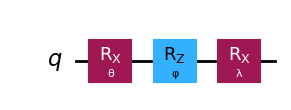

In [4]:
# Pre-defined ansatz circuit and operator class for Hamiltonian

ansatz = ansatz3

num_params = ansatz.num_parameters
print("This circuit has ", num_params, "parameters")

ansatz.draw("mpl", style="iqp")

### Step 2: Optimize for target hardware

When running a calculation on a real quantum computer, we don't just care about the logic of the quantum circuit. We also care about things like what operations can be performed by that particular quantum computer, and where on the quantum computer are the qubits we are using. Are they right next to each other? Are they far apart? Therefore, the next step is to rewrite our circuit using gates that are natural for the quantum computer we'll use, and taking qubit layout into account. This can be done by `transpilation` - after this process, you can see our simple ansatz converted into a different set of gates, and our abstract qubits will be mapped into physical qubits on a real quantum computer.



Backend: {config.backend_name}
Native gates:  ['cz', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else', 'for_loop', 'switch_case'] ,


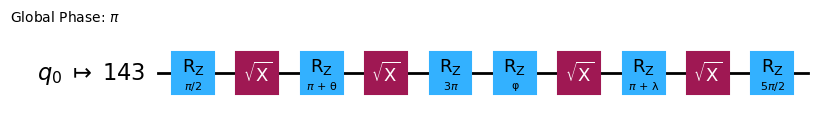

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

config = backend.configuration()

print("Backend: {config.backend_name}")
print("Native gates: ", config.supported_instructions, ",")


target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

You can see the `rx, rz` gates of our ansatz were converted into a series of `rz, sx` gates, which are the native gates of our backend. Also, you can see our `q0` is now mapped into the fifth physical qubit. We also need to map our Hamiltonian according to these changes, as in the following code:



In [6]:
Hamiltonian_isa = Hamiltonian.apply_layout(layout=ansatz_isa.layout)

### Step 3: Execute on target hardware

Now it is time to run our VQE on a real QPU. For this, first we need a cost function for the optimization process, which evaluates the expectation value of the Hamiltonian with a quantum state, generated by the ansatz. Don't worry! You don't need to code everything by yourself. We prepared a function for this, and all you need to do is run the cell below.



In [7]:
def cost_func(params, ansatz, hamiltonian, estimator, cost_history_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]


    if "param_history" not in cost_history_dict:
        cost_history_dict["param_history"] = []
    cost_history_dict["param_history"].append(np.array(params, dtype=float).ravel())

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

Finally, we prepare initial parameters for our ansatz and its optimization process. You can simply use all zeroes or random values. We have selected initial parameters below, but feel free to comment or uncomment lines in the cell to sample parameters randomly, uniformly from 0 to $2\pi$.



In [8]:
# x0 = np.random.uniform(0, 2*pi, 3)
x0 = [1, 1, 0]

In [9]:
from typing import Any


from scipy.optimize import minimize
from qiskit_ibm_runtime import Batch

batch = Batch(backend=backend)

cost_history_dict: dict[str, Any] = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "param_history": []
}
estimator = Estimator(mode=batch)
estimator.options.default_shots = 10000

res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, Hamiltonian_isa, estimator, cost_history_dict),
    method="cobyla",
    options={"maxiter": 10, "tol": 0.01},
)

batch.close()

Iters. done: 1 [Current cost: -0.3256965]
Iters. done: 2 [Current cost: -0.465348]
Iters. done: 3 [Current cost: -0.38819819999999994]
Iters. done: 4 [Current cost: -0.38282879999999997]
Iters. done: 5 [Current cost: -0.45691709999999996]
Iters. done: 6 [Current cost: -0.40148039999999996]
Iters. done: 7 [Current cost: -0.46153289999999997]
Iters. done: 8 [Current cost: -0.4652067]
Iters. done: 9 [Current cost: -0.4671378]
Iters. done: 10 [Current cost: -0.4656306]


In [10]:
h_vqe = res.fun
print("The reference ground state energy is ", min(eigenvalues))
print("The computed ground state energy is ", h_vqe)

The reference ground state energy is  (-0.471+0j)
The computed ground state energy is  -0.4671378


### Step 4: Post-process

It is time to take a look at how our classical optimizer worked. Run the cell below and see the convergence pattern.



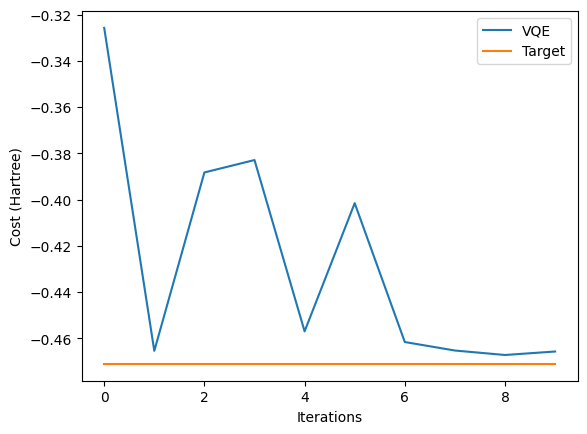

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x = np.linspace(0, 10, 10)

# Define the constant function
y_constant = np.full_like(x, h)
ax.plot(
    range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label="VQE"
)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost (Hartree)")
ax.plot(y_constant, label="Target")
plt.legend()
plt.draw()

### QSD diagnostics for Hydrogen atom VQE (init / mid / final)

We capture three optimizer iterations (initial, midpoint, final), compute the corresponding statevectors, and render QSD plots.


In [13]:
def _statevector_from_params(circuit, params):
    return Statevector.from_instruction(circuit.assign_parameters(params)).data

In [14]:
from typing import Any


from qsd import plot_qsd
from pathlib import Path

def plot_from_cost_history(circuit: QuantumCircuit, cost_history_dict:dict[str, Any], caption:str, save_path: str | None =None)  -> None:

    if not cost_history_dict.get("param_history"):
        raise RuntimeError("No parameter history recorded. Re-run the VQE cell above.")

    params_hist = cost_history_dict["param_history"]
    idx_init = 0
    idx_mid = len(params_hist) // 2
    idx_final = len(params_hist) - 1

    statevectors = {
        "init": _statevector_from_params(circuit, params_hist[idx_init]),
        "mid": _statevector_from_params(circuit, params_hist[idx_mid]),
        "final": _statevector_from_params(circuit, params_hist[idx_final]),
    }
    print(statevectors)

    if save_path:
        fig_dir = Path(save_path)
        fig_dir.mkdir(parents=True, exist_ok=True)

    for key, statevector in statevectors.items():

        plot_qsd(
            statevector,
            grouping="hamming",
            ordering="lex",
            theme="light",
            show_metrics=True,
            style="paper",
            annotate_threshold=0.0,
            phase_gauge=("index", 0),
            save_path=str(fig_dir / f"{caption.lower().replace(" ", "_")}_qsd_{key}.png") if save_path else None,
            caption=f"{caption} | {key}",
        )

    

In [15]:
plot_from_cost_history(ansatz, cost_history_dict, "Hydrogen atom VQE", "figures/vqe_example")

{'init': array([0.54030231+0.j        , 0.        -0.84147098j]), 'mid': array([ 0.35380869+0.12103069j, -0.05979176-0.92552468j]), 'final': array([-0.05151393+0.02745786j, -0.01386877-0.9981984j ])}


In [16]:
from __future__ import annotations

from pathlib import Path
from typing import Any
import tempfile

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qsd import plot_qsd

def plot_qsd_history_widget(
    circuit: QuantumCircuit,
    cost_history_dict: dict[str, Any],
    caption: str,
    step: int = 1,
    show_play: bool = True,
    save_path: str | None = None,
    fps: int = 6,
):
    """
    Build QSD frames and return an interactive widget to scrub forward/backward.
    Keyboard stepper: left/right arrows (requires ipyevents).
    If save_path is provided, saves a single GIF there.
    """
    def _statevector_from_params(circ, params):
        return Statevector.from_instruction(circ.assign_parameters(params)).data

    if not cost_history_dict.get("param_history"):
        raise RuntimeError("No parameter history recorded. Re-run the VQE cell above.")

    params_hist = cost_history_dict["param_history"]
    indices = list(range(0, len(params_hist), max(1, step)))
    if indices[-1] != len(params_hist) - 1:
        indices.append(len(params_hist) - 1)

    # temp storage for frames
    tmpdir = Path(tempfile.mkdtemp())
    frame_paths = []

    for i, idx in enumerate(indices):
        statevector = _statevector_from_params(circuit, params_hist[idx])
        frame_path = tmpdir / f"frame_{i:04d}.png"

        plot_qsd(
            statevector,
            grouping="hamming",
            ordering="lex",
            theme="light",
            show_metrics=True,
            style="paper",
            annotate_threshold=0.0,
            phase_gauge=("index", 0),
            save_path=str(frame_path),
            caption=f"{caption} | iter {idx}",
        )
        frame_paths.append(frame_path)

    # Save GIF if requested
    if save_path:
        import imageio.v3 as iio

        save_path = Path(save_path)
        if save_path.is_dir() or save_path.suffix == "":
            save_path = save_path / f"{caption.lower().replace(' ', '_')}_qsd.gif"
        save_path.parent.mkdir(parents=True, exist_ok=True)

        frames = [iio.imread(p) for p in frame_paths]
        iio.imwrite(save_path, frames, duration=1 / max(1, fps), loop=0)

    # Widgets
    import ipywidgets as widgets
    from IPython.display import display

    slider = widgets.IntSlider(
        value=0, min=0, max=len(frame_paths) - 1, step=1, description="frame"
    )
    img = widgets.Image(
        value=frame_paths[0].read_bytes(),
        format="png",
        width=700,
    )

    def _on_change(change):
        if change["name"] == "value":
            img.value = frame_paths[change["new"]].read_bytes()

    slider.observe(_on_change)

    if show_play:
        play = widgets.Play(
            value=0, min=0, max=len(frame_paths) - 1, step=1, interval=200
        )
        widgets.jslink((play, "value"), (slider, "value"))
        controls = widgets.HBox([play, slider])
    else:
        controls = slider

    # Keyboard stepper via ipyevents (left/right arrows)
    try:
        import ipyevents  # pip install ipyevents

        key_area = widgets.Box([img])
        ev = ipyevents.Event(
            source=key_area, watched_events=["keydown"], prevent_default_action=True
        )

        def _on_key(event):
            if event.get("key") == "ArrowRight":
                slider.value = min(slider.value + 1, slider.max)
            elif event.get("key") == "ArrowLeft":
                slider.value = max(slider.value - 1, slider.min)

        ev.on_dom_event(_on_key)
        ui = widgets.VBox([controls, key_area])
    except Exception:
        ui = widgets.VBox([controls, img])

    display(ui)
    return ui, frame_paths


In [26]:
plot_qsd_history_widget(circuit=ansatz, cost_history_dict=cost_history_dict, caption="Hydrogen atom VQE", save_path="figures/vqe_example")

(VBox(children=(HBox(children=(Play(value=0, interval=200, max=9), IntSlider(value=0, description='frame', max=9))), Box(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05+\x00\x00\x03\xc2\x08\x06\x00\x00\x00\x90\xa9\x8dU\x00\x00\x00:tEX...', width='700'),)))),
 [PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmp6vg6y3_3/frame_0000.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmp6vg6y3_3/frame_0001.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmp6vg6y3_3/frame_0002.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmp6vg6y3_3/frame_0003.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmp6vg6y3_3/frame_0004.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmp6vg6y3_3/frame_0005.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmp6vg6y3_3/frame_0006.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmp6vg6y3_3

## Compute the ground state energy of the hydrogen molecule with VQE

Now that we have looked at the overall process of VQE using $H$ atoms, we will now calculate the ground state energy of the $H_2$ molecule more quickly.



### Step 1: Map the problem to quantum circuits and operators

Here we also provide you with a one-qubit Hamiltonian that uses the STO-6G basis and the Jordan-Wigner transformation, with qubit reduction by using a symmetry of the Hamiltonian. Note that we used an atomic distance between two hydrogen atoms of `0.735` $\mathring A$.

Unlike the calculation of a single hydrogen atom ($H$), in order to compute the ground state of a hydrogen molecule($H_2$), we must also consider the repulsive force acting between the nuclei of the two hydrogen atoms, in addition to the energy associated with the electronic orbitals. In this step, we will give this value as a constant, and we will actually calculate this value in the check-in problem.
$\hat{H} = -1.04886 I + -0.79674 Z + 0.18122 X$



In [19]:
h2_hamiltonian = SparsePauliOp.from_list(
    [("I", -1.04886087), ("Z", -0.7967368), ("X", 0.18121804)]
)

# exact ground state energy of hamiltonian
nuclear_repulsion = 0.71997
A = np.array(h2_hamiltonian)
eigenvalues, eigenvectors = np.linalg.eig(A)
print("Electronic ground state energy (Hartree): ", min(eigenvalues).real)
print("Nuclear repulsion energy (Hartree): ", nuclear_repulsion)
print(
    "Total ground state energy (Hartree): ", min(eigenvalues).real + nuclear_repulsion
)
h2 = min(eigenvalues).real + nuclear_repulsion

Electronic ground state energy (Hartree):  -1.8659468547627318
Nuclear repulsion energy (Hartree):  0.71997
Total ground state energy (Hartree):  -1.1459768547627318


### Step 2: Optimize for target hardware

Since the number of qubits used by the previous VQE and Hamiltonian is the same as the backend to be used for execution, we will use the existing ansatz and its optimized form.



In [20]:
h2_hamiltonian_isa = h2_hamiltonian.apply_layout(layout=ansatz_isa.layout)

### Step 3: Execute on target hardware

Now it's time to do the calculations on the actual QPU. Almost everything is the same, but we will use the appropriate initial point to fit the Hamiltonian. Also, at an iterative part, some of the settings of the `Estimator`, which is used to calculate the Hamiltonian's expectations for the ansatz in the QPU, will be set slightly differently from the previous calculations. We will discuss this change further in a check-in question.



In [21]:
x0 = [2, 0, 0]

In [22]:
# QPU time 4min for ibm_brisbane
batch = Batch(backend=backend)

cost_history_dict_h2 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "param_history": [],
}
estimator = Estimator(mode=batch)
estimator.options.default_shots = 10000

res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, h2_hamiltonian_isa, estimator, cost_history_dict_h2),
    method="cobyla",
    options={"maxiter": 15},
)

batch.close()

Iters. done: 1 [Current cost: -0.7327419633119998]
Iters. done: 2 [Current cost: -0.2781326881359999]
Iters. done: 3 [Current cost: -0.2729548327999999]
Iters. done: 4 [Current cost: -0.5831539287839999]
Iters. done: 5 [Current cost: -1.720098077576]
Iters. done: 6 [Current cost: -0.6865393492399999]
Iters. done: 7 [Current cost: -1.592018936384]
Iters. done: 8 [Current cost: -1.635930136504]
Iters. done: 9 [Current cost: -1.571006252448]
Iters. done: 10 [Current cost: -1.642918980768]
Iters. done: 11 [Current cost: -1.8319312052799999]
Iters. done: 12 [Current cost: -1.853823074448]
Iters. done: 13 [Current cost: -1.8210657279919997]
Iters. done: 14 [Current cost: -1.8556558803760002]
Iters. done: 15 [Current cost: -1.846912374264]


In [23]:
h2_vqe = res.fun + nuclear_repulsion
print(
    "The reference ground state energy is ", min(eigenvalues).real + nuclear_repulsion
)
print("The computed ground state energy is ", h2_vqe)

The reference ground state energy is  -1.1459768547627318
The computed ground state energy is  -1.1356858803760002


### QSD diagnostics for H$_2$ VQE (init / mid / final)

We capture three optimizer iterations (initial, midpoint, final), compute the corresponding statevectors, and render QSD plots.


In [24]:
plot_from_cost_history(ansatz, cost_history_dict_h2, r"$H_2$ molecule VQE", "figures/vqe_example")

{'init': array([0.54030231+0.j        , 0.        -0.84147098j]), 'mid': array([ 0.90279944+0.13357672j, -0.22260706+0.34286518j]), 'final': array([ 0.99233269+0.04584043j, -0.07370785+0.08798658j])}


In [27]:
plot_qsd_history_widget(circuit=ansatz, cost_history_dict=cost_history_dict_h2, caption=r"$H_2$ molecule VQE", save_path="figures/vqe_example")

(VBox(children=(HBox(children=(Play(value=0, interval=200, max=14), IntSlider(value=0, description='frame', max=14))), Box(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05+\x00\x00\x03\xc2\x08\x06\x00\x00\x00\x90\xa9\x8dU\x00\x00\x00:tEX...', width='700'),)))),
 [PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmpcagxu9dm/frame_0000.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmpcagxu9dm/frame_0001.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmpcagxu9dm/frame_0002.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmpcagxu9dm/frame_0003.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmpcagxu9dm/frame_0004.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmpcagxu9dm/frame_0005.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmpcagxu9dm/frame_0006.png'),
  PosixPath('/var/folders/mv/jppb68jj4495fl3hmy9jwqs40000gn/T/tmpcagxu9

Despite VQE theoretically providing an upper bound to the true ground state energy, practical implementations on real or noisy simulated quantum hardware, as well as approximations made in preparing the Hamiltonian (like basis sets or qubit reduction), can introduce errors that sometimes result in a measured energy slightly lower than the exact theoretical value or a specific numerical reference. Although there are some errors, the results seem to be satisfactory, especially given the small number of steps. Now, let's finish this VQE calculation by looking at how the optimizer worked.



### Step 4: Post-process



/Users/siddharthgolecha/Projects/Hilbert Lattice Diagram/hilbert-lattice-diagram/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  multiarray.copyto(res, fill_value, casting='unsafe')


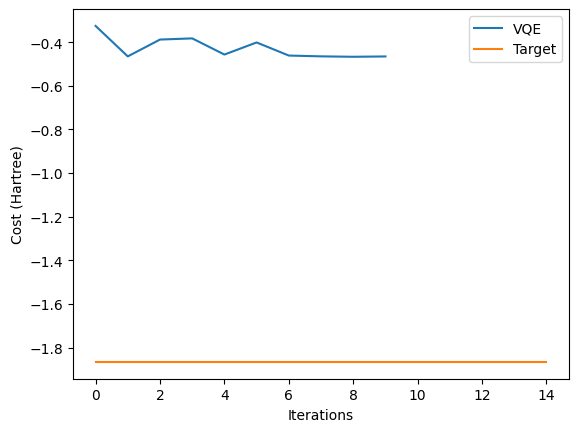

In [28]:
fig, ax = plt.subplots()
x = np.linspace(0, 5, 15)

# Define the constant function
y_constant = np.full_like(x, min(eigenvalues))
ax.plot(
    range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label="VQE"
)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost (Hartree)")
ax.plot(y_constant, label="Target")
plt.legend()
plt.draw()

#### Check your understanding

Let's compute the nuclear repulsion energy of $H_2$ molecule, which we included as a constant value (0.71997 Hartree).

![H2 molecule](/learning/images/modules/computer-science/vqe/h2.avif)

<details>
  <summary>
    Please use [Coulomb's law](https://en.wikipedia.org/wiki/Coulomb%27s_law) and use [atomic unit](https://en.wikipedia.org/wiki/Atomic_units) to make sure you get the value in `Hartree`.
  </summary>

  **Answer:**

  Since both hydrogen nuclei are positively charged, they repel each other due to electrostatic force. This repulsion is described by Coulomb's law:

  $E_{repulsive} = \frac{e^2}{4\pi\epsilon_0R}$,

  where $e$ is a charge of proton, $\epsilon_0$ is a vacuum permittivity, and $R$ is the distance between the two nuclei, measured in meters or Bohr radii in unit of joules(J).

  To compute this energy in Hartrees, we need to convert the above equation into the Atomic Unit (AU) system. In AU, $e^2 = 1$, $4\pi\epsilon_0=1$ and Bohr radius ($a_0$) is 1 and becomes the fundamental length scale in AU. With these simplifications, Coulomb's law reduces to:

  $E_{repulsion} = \frac{1}{R}$,

  where $R$ must be measured in Bohr radii ($a_0$).

  To convert the given nuclear separation in $\r{A}$ into $a_0$, we need this conversion relation:

  $1\r{A} = 1.88973 a_0$

  so $0.735\r{A}$ becomes $0.735 * 1.88973 = 1.38895 a_0$.

  Therefore, the nuclear repulsion energy of a given $H_2$ is

  $E_{repulsion} = \frac{1}{R} = \frac{1}{1.38895} = 0.71997 Hartree$
</details>



## Compute reaction energy of $H + H = H_2$

Now let's use what we've obtained! You've used VQE, a variational quantum eigensolver, to calculate the ground state energy of the $H$ atom and of the $H_2$ molecule. What's left is to use the calculated values to get the reaction energy of the $H+H=H_2$ process.

Reaction energy is the energy change that happens when substances react to form new substances. Imagine you are building something: sometimes you need to put energy into it (like stacking blocks), and sometimes energy is released (like a ball rolling downhill). In chemistry, reactions either absorb energy (endothermic) or release energy (exothermic).

The reaction energy of $H+H = H_2$ process can be compute by the following formula:

$E_{reaction} = E_{H_2} - (E_H + E_H)$

By running the cell below, let's see this visually. Here we will use the exact ground state value of each Hamiltonian, and we'll compare the reaction energy of the exact solution and VQE results.



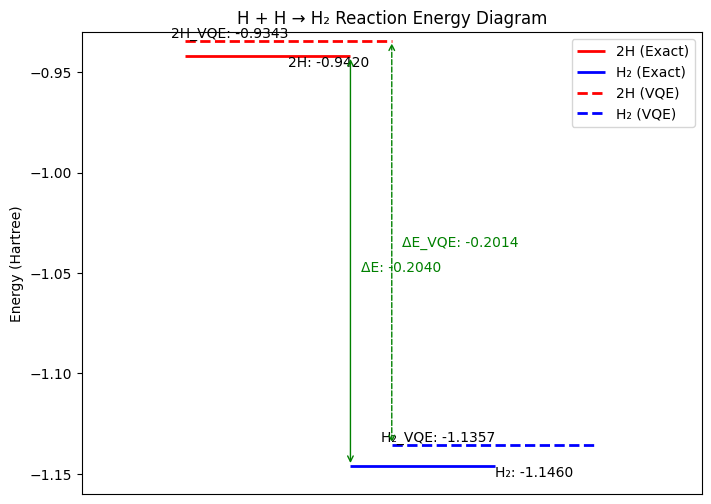

In [29]:
# Theoretical values
E_H_theo = h.real
E_H2_theo = h2

# Experimental values
E_H_exp = h_vqe
E_H2_exp = h2_vqe

# Calculate reaction energies
E_reaction_theo = E_H2_theo - (2 * E_H_theo)
E_reaction_exp = E_H2_exp - (2 * E_H_exp)

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 3)
ax.set_ylim(-1.16, -0.93)  # Adjust y-axis range to highlight differences
ax.set_xticks([])
ax.set_ylabel("Energy (Hartree)")
ax.set_title("H + H → H₂ Reaction Energy Diagram")

# Plot theoretical energy levels
ax.hlines(
    y=2 * E_H_theo, xmin=0.5, xmax=1.3, linewidth=2, color="r", label="2H (Exact)"
)
ax.hlines(y=E_H2_theo, xmin=1.3, xmax=2, linewidth=2, color="b", label="H₂ (Exact)")

# Plot experimental energy levels
ax.hlines(
    y=2 * E_H_exp,
    xmin=0.5,
    xmax=1.5,
    linewidth=2,
    color="r",
    linestyle="dashed",
    label="2H (VQE)",
)
ax.hlines(
    y=E_H2_exp,
    xmin=1.5,
    xmax=2.5,
    linewidth=2,
    color="b",
    linestyle="dashed",
    label="H₂ (VQE)",
)

# Add labels
ax.text(
    1,
    2 * E_H_theo,
    f"2H: {2*E_H_theo:.4f}",
    verticalalignment="top",
    horizontalalignment="left",
)
ax.text(
    2,
    E_H2_theo,
    f"H₂: {E_H2_theo:.4f}",
    verticalalignment="top",
    horizontalalignment="left",
)
ax.text(
    1,
    2 * E_H_exp,
    f"2H_VQE: {2*E_H_exp:.4f}",
    verticalalignment="bottom",
    horizontalalignment="right",
)
ax.text(
    2,
    E_H2_exp,
    f"H₂_VQE: {E_H2_exp:.4f}",
    verticalalignment="bottom",
    horizontalalignment="right",
)

# Add arrows for reaction energy with ΔE label in the middle
mid_y_theo = (2 * E_H_theo + E_H2_theo) / 2
mid_y_exp = (2 * E_H_exp + E_H2_exp) / 2
ax.annotate(
    "",
    xy=(1.3, E_H2_theo),
    xytext=(1.3, 2 * E_H_theo),
    arrowprops=dict(arrowstyle="<->", color="g"),
)
ax.text(
    1.35, mid_y_theo, f"ΔE: {E_reaction_theo:.4f}", color="g", verticalalignment="top"
)

ax.annotate(
    "",
    xy=(1.5, E_H2_exp),
    xytext=(1.5, 2 * E_H_exp),
    arrowprops=dict(arrowstyle="<->", color="g", linestyle="dashed"),
)
ax.text(
    1.55,
    mid_y_exp,
    f"ΔE_VQE: {E_reaction_exp:.4f}",
    color="g",
    verticalalignment="center",
)

# Add legend
ax.legend()

plt.show()

As shown in the figure, although there are some errors, the exact ground state energy of Hamiltonians and the reaction energy calculated using the VQE results are similar, close to -0.2 Hartree.

It should be noted here that the reaction energy of this process has a negative value, which means that the energy is released through the process, and the resulting molecule has a lower energy than two single atoms.



6.  Conclusion

Let's summarize what we've learned so far.

We first looked at two important approximation techniques needed to solve quantum chemistry problems: the variational principle and basis set choices, which are both fundamental to VQE. We explored the variational principle by hand, calculating the ground state energy of the simple harmonic oscillator.

Next, we explored VQE, a widely-used algorithm for calculating the ground state energy of a quantum system. We ran code to calculate the ground state energies for atomic hydrogen ($H$) and the hydrogen molecule ($H_2$). In particular, we learned that it is necessary to obtain the appropriate molecular Hamiltonian for the system and to transform it into a form executable on a quantum computer. We also saw that the ansatz, a parameterized quantum circuit, is needed to prepare trial quantum states within VQE, and we discussed the importance of choosing an appropriate ansatz circuit structure. We also learned that VQE relies on an iterative optimization process using a classical computer, guiding the quantum circuit to find the lowest energy state, and saw how the process converges.

Finally, we used the computed ground state energies of $H$ and $H_2$ obtained through VQE to calculate the reaction energy for the process $H + H \rightarrow H_2$.

VQE is a powerful near-term quantum algorithm, but it's important to be aware of its limitations. The performance of VQE heavily depends on the choice of the ansatz – finding an efficiently preparable ansatz that can accurately represent the true ground state becomes challenging for larger, more complex molecules. Furthermore, current quantum hardware is susceptible to noise, which can impact the accuracy of VQE results, particularly for deeper circuits or larger numbers of qubits. Despite these challenges, VQE serves as a foundational algorithm, and ongoing research is exploring more sophisticated variational methods and error mitigation techniques to push the boundaries of what is possible in quantum chemistry on near-term quantum computers. For instance, algorithms like Sample-based Quantum Diagonalization (SQD) are being developed, which leverage samples obtained from quantum circuits combined with classical diagonalization in a subspace to improve energy estimation and address some of the limitations faced by VQE, particularly regarding measurement efficiency and noise robustness.



## References

*   \[[ref 1](https://link.springer.com/article/10.1007/BF02650179) ] Richard P. Feynman, Simulating Physics with Computers, International Journal of Theoretical Physics, 1982.
*   [\[ref 2\]](https://link.springer.com/chapter/10.1007/978-1-4614-8730-2_10) Marov, M.Y. (2015). The Structure of the Universe. In: The Fundamentals of Modern Astrophysics. Springer, New York, NY.
*   \[[ref 3](https://www.ibm.com/quantum/blog/photoresists-quantum-chemistry-jsr)] How to solve difficult chemical engineering problems with quantum computing, IBM Research Blog, 2023.
*   \[[ref 4](https://ieeexplore.ieee.org/document/8585034)] Y. Cao, J. Romero and A. Aspuru-Guzik, "Potential of quantum computing for drug discovery," in IBM Journal of Research and Development, vol. 62, no. 6, pp. 6:1-6:20, 1 Nov.-Dec. 2018
*   \[[ref 5](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.32.170)] Present State of Molecular Structure Calculation, REv. Mod. Phys. 32, 170, 1960
*   \[[ref 6](https://jmsh.springeropen.com/articles/10.1186/s41313-021-00032-6)] Fedorov, D.A., Peng, B., Govind, N. et al. VQE method: a short survey and recent developments. Mater Theory 6, 2 (2022)



© IBM Corp., 2017-2026